# Training Linear Models

## Imports and Parameters

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [3]:
# Reproducibility
np.random.seed(42)

# Closed form solution for linear regression

Text(0, 0.5, '$y$')

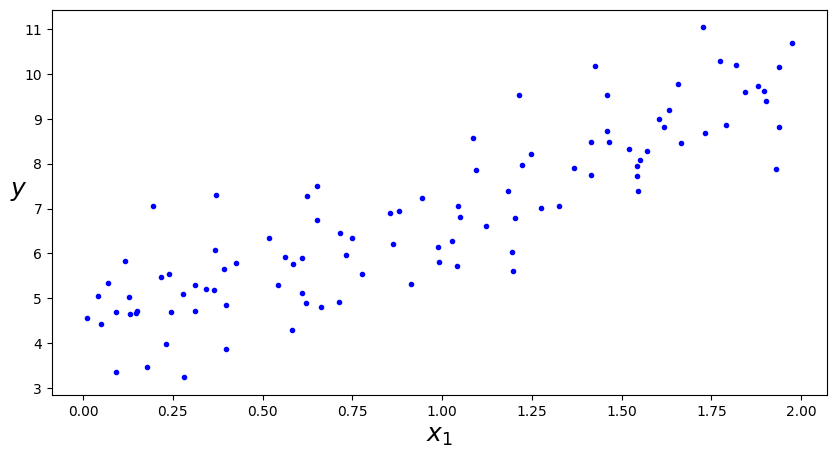

In [4]:
# Generate some data to test the equation

m = 100 # number of instances
X = 2 * np.random.rand(m, 1)
y = 4 + 3 * X + np.random.randn(m, 1)

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)

In [5]:
# Computing the best theta using the Normal Equation

from sklearn.preprocessing import add_dummy_feature
X_b = add_dummy_feature(X) 		# add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

In [6]:
theta_best

array([[4.21509616],
       [2.77011339]])

In [7]:
# Making predictions using theta_best
X_new = np.array([[0], [2]])	# two instances at the extremes
X_new_b = add_dummy_feature(X_new)		# add x0 = 1 to each instance
y_predict = X_new_b @ theta_best

In [8]:
y_predict

array([[4.21509616],
       [9.75532293]])

In [9]:
x_orig = np.linspace(0, 2, 100)
y_orig = 4 + 3 * x_orig

y_bad = 2 + 2 * x_orig

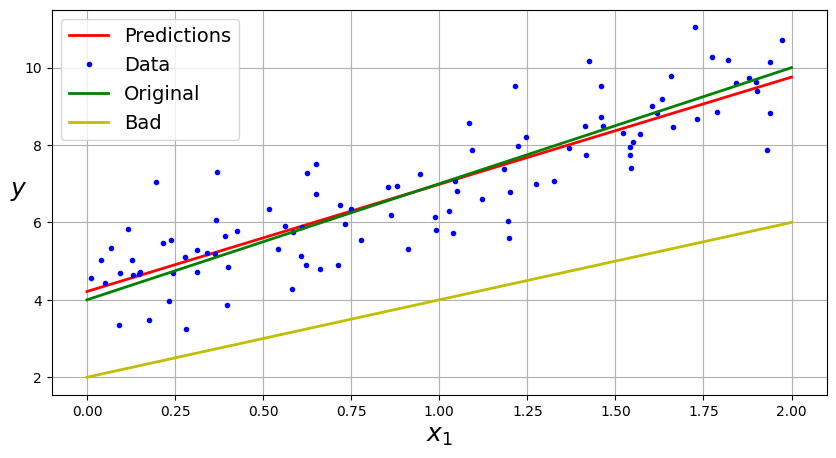

In [10]:
# Plot the model
plt.figure(figsize=(10, 5))
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.", label="Data")
plt.plot(x_orig, y_orig, "g-", linewidth=2, label="Original")
plt.plot(x_orig, y_bad, "y-", linewidth=2, label="Bad")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.grid()
plt.legend()

In [11]:
# Using Scikit-Learn
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
print(f"Using Scikit-Learn:")
print(f"Intercept: {lin_reg.intercept_.item():.3f}; Slope:{ lin_reg.coef_.item():.3f}")
preds = lin_reg.predict(X_new)
print(f"Points (x, y): (0, {preds[0].item():.3f}); (2, {preds[1].item():.3f})")
print(f"Using Normal Equation:")
print(f"Intercept: {theta_best[0].item():.3f}; Slope:{ theta_best[1].item():.3f}")
print(f"Points (x, y): (0, {y_predict[0].item():.3f}); (2, {y_predict[1].item():.3f})")

Using Scikit-Learn:
Intercept: 4.215; Slope:2.770
Points (x, y): (0, 4.215); (2, 9.755)
Using Normal Equation:
Intercept: 4.215; Slope:2.770
Points (x, y): (0, 4.215); (2, 9.755)


Taking a look at the cost function for different theta values.

In [12]:
# Dividing theta paramters into intercept and slope
# slope = 2.77; intercept = 4.22
intercept, slope = theta_best[0].item(), theta_best[1].item()

slopes = np.linspace(slope - 1, slope + 1, 100)
intercepts = np.linspace(intercept - 2, intercept + 2, 100)

# Compute the cost function for each combination of slope and intercept
def linear_function(x, slope, intercept):
	return slope * x + intercept

def MSE(y, y_pred):
	return np.mean((y - y_pred) ** 2)

costs = np.zeros((100, 100))
for i, s in enumerate(slopes):
	for j, inter in enumerate(intercepts):
		y_pred = linear_function(X, s, inter)
		costs[i, j] = MSE(y, y_pred)

In [13]:
def find_value(array, value):
	return np.abs(array - value).argmin()

best_slope_idx = find_value(slopes, slope)
best_intercept_idx = find_value(intercepts, intercept)

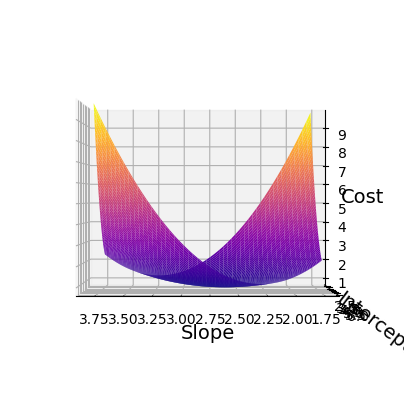

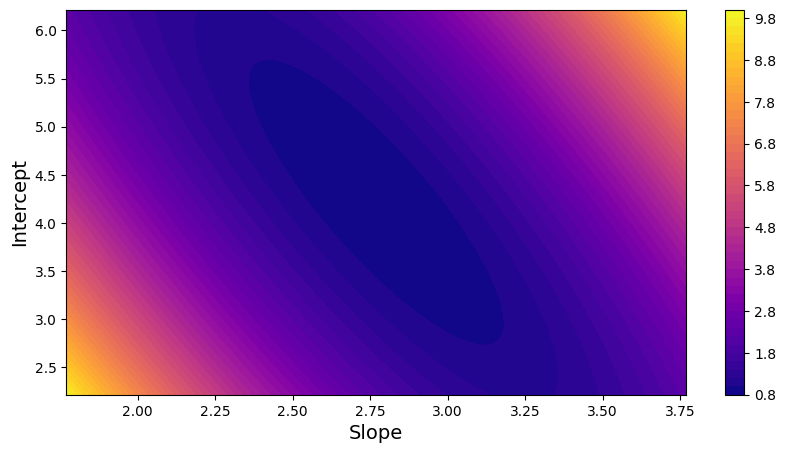

In [29]:
# Plot the cost function in 3D
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, projection='3d')
X_mesh, Y_mesh = np.meshgrid(slopes, intercepts)
ax.plot_surface(X_mesh, Y_mesh, costs, cmap='plasma')
ax.view_init(elev=0, azim=90)
ax.set_xlabel('Slope')
ax.set_ylabel('Intercept')
ax.set_zlabel('Cost')
plt.show()


# Plot the cost function in 2D
plt.figure(figsize=(10, 5))
plt.contourf(X_mesh, Y_mesh, costs, levels=50, cmap='plasma')
plt.xlabel('Slope')
plt.ylabel('Intercept')
plt.colorbar()
plt.show()

In [36]:
width = 3
costs[best_slope_idx-width:best_slope_idx+width, best_intercept_idx]

array([0.81585223, 0.81206112, 0.80927786, 0.80750245, 0.80673488,
       0.80697517])

In [37]:
with open("../Test/data.dat", 'w') as f:
	f.write("Slope, Intercept, Cost\n")
	for i in range(100):
		for j in range(100):
			f.write(f"{slopes[i]}, {intercepts[j]}, {costs[i, j]}\n")
	

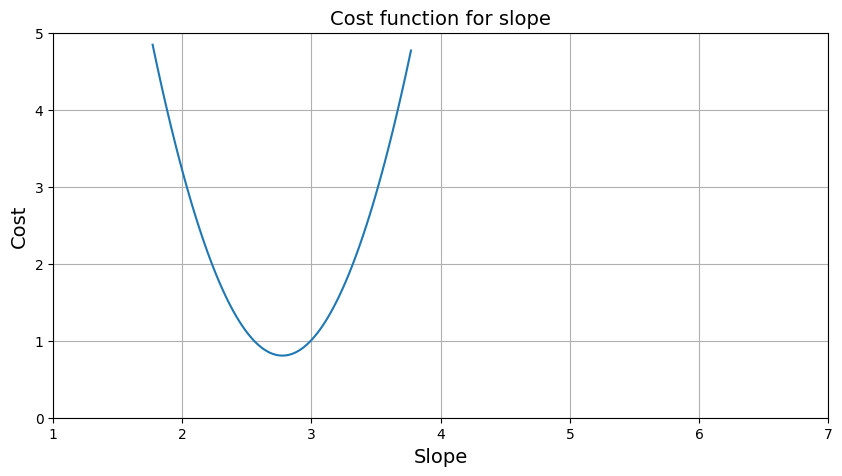

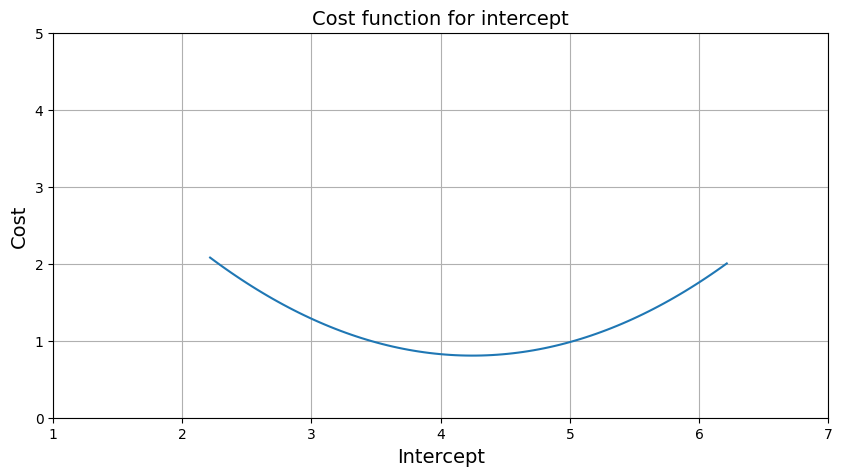

In [16]:
# Plot cost function for slope and intercept separately

x_range = (1, 7)
y_range = (0, 5)

plt.figure(figsize=(10, 5))
plt.plot(slopes, costs[best_slope_idx, :])
plt.xlabel('Slope')
plt.xlim(x_range)
plt.ylabel('Cost')
plt.ylim(y_range)
plt.title('Cost function for slope')
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(intercepts, costs[:, best_intercept_idx])
plt.xlabel('Intercept')
plt.xlim(x_range)
plt.ylabel('Cost')
plt.ylim(y_range)
plt.title('Cost function for intercept')
plt.grid()
plt.show()

# Gradient descent

In [17]:
# A simple implementation of gradient descent

eta = 0.1 		# learning rate
epochs = 10000	# number of iterations
m = len(X_b) 	# number of instances

# Initialize theta at a random value
np.random.seed(42)
theta = np.random.randn(2, 1)

def batch_GD(X, y, eta, epochs):
	batch_theta_path = []
	theta = np.random.randn(2, 1)
	for epoch in range(epochs):
		gradients = 2/m * X_b.T @ (X_b @ theta - y)
		theta = theta - eta * gradients
		batch_theta_path.append(theta)
	return theta, batch_theta_path

theta_batch, theta_path_batch = batch_GD(X_b, y, eta, epochs)

print(f"Using Gradient Descent:")
print(f"Values for the generated data: ")
print("Intercept: 4; Slope: 3")
print(f"Intercept: {theta_batch[0].item():.3f}; Slope:{ theta_batch[1].item():.3f}")

Using Gradient Descent:
Values for the generated data: 
Intercept: 4; Slope: 3
Intercept: 4.215; Slope:2.770


# Stochastic Gradient Descent

In [18]:
n_epochs = 50
t0, t1 = 5, 50 	# learning schedule hyperparameters
m = len(X_b)

def learning_schedule(t):
	return t0 / (t + t1)

def stocastic_GD(X, y, theta, n_epochs, random_state=42):
	np.random.seed(random_state)
	theta = np.random.randn(2, 1)
	theta_path_sgd = []
	for epoch in range(n_epochs):
		for i in range(m):
			random_index = np.random.randint(m)
			xi = X_b[random_index:random_index+1]
			yi = y[random_index:random_index+1]
			gradients = 2 * xi.T @ (xi @ theta - yi)
			eta = learning_schedule(epoch * m + i)
			theta = theta - eta * gradients
			theta_path_sgd.append(theta)

	return theta, theta_path_sgd

theta_SGD, theta_path_sgd = stocastic_GD(X_b, y, theta, n_epochs)

In [19]:
theta_SGD

array([[4.21076011],
       [2.74856079]])

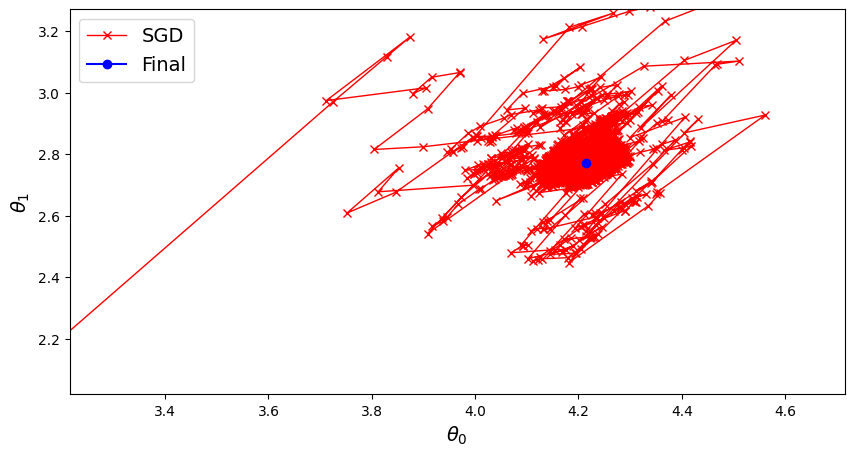

In [20]:
# Thetas path
theta_path_sgd = np.array(theta_path_sgd)

plt.figure(figsize=(10, 5))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-x", linewidth=1, label="SGD")
plt.plot(theta_best[0], theta_best[1], "b-o", label="Final")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
plt.xlim(theta_best[0]-1, theta_best[0]+0.5)
plt.ylim(theta_best[1]-0.75, theta_best[1]+0.5)
plt.legend()

In [21]:
# Implementing this using sci-kit learn
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None,
					   eta0=0.01, n_iter_no_change=100, random_state=42)

# .ravel() is used to convert the y array to a 1D array
# y.shape = (100, 1) -> y.ravel().shape = (100,)
sgd_reg.fit(X, y.ravel())

SGDRegressor(n_iter_no_change=100, penalty=None, random_state=42, tol=1e-05)

In [22]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21278812]), array([2.77270267]))

# Mini-batch Gradient Descent

In [23]:
# Mix of Batch and Stochastic Gradient Descent

def mini_bath_GD(X, y, eta=0.1, n_epochs=50, batch_size=20):
	theta = np.random.randn(2, 1)
	theta_path_mgd = []
	m = len(X_b)

	for epoch in range(n_epochs):
		shuffled_indices = np.random.permutation(m)
		X_b_shuffled = X_b[shuffled_indices]
		y_shuffled = y[shuffled_indices]

		for i in range(0, m, batch_size):
			xi = X_b_shuffled[i:i+batch_size]
			yi = y_shuffled[i:i+batch_size]
			gradients = 2/batch_size * xi.T @ (xi @ theta - yi)
			# eta = learning_schedule(epoch * m + i)
			theta = theta - eta * gradients
			theta_path_mgd.append(theta)

	return theta, theta_path_mgd

In [24]:
theta_mini, theta_path_mgd = mini_bath_GD(X_b, y)

In [57]:
def compare_theta_paths(theta_best, theta_paths, line_style , labels, figsize=(10, 5), rel_xlim=(-1, 0.5), rel_ylim=(-0.75, 0.5)):
	
	plt.figure(figsize=figsize)
	for i, path in enumerate(theta_paths):
		path = np.array(path)
		plt.plot(path[:, 0], path[:, 1], line_style[i], linewidth=1, label=labels[i], alpha=0.5)
	plt.plot(theta_best[0], theta_best[1], "k-o", label="Final")
	plt.xlabel(r"$\theta_0$")
	plt.ylabel(r"$\theta_1$")
	plt.xlim(theta_best[0]+rel_xlim[0], theta_best[0]+rel_xlim[1])
	plt.ylim(theta_best[1]+rel_ylim[0], theta_best[1]+rel_ylim[1])
	plt.legend()
	plt.show()

In [50]:
theta_path_batch[1:3,0]

array([[2.17002757],
       [2.52437359]])

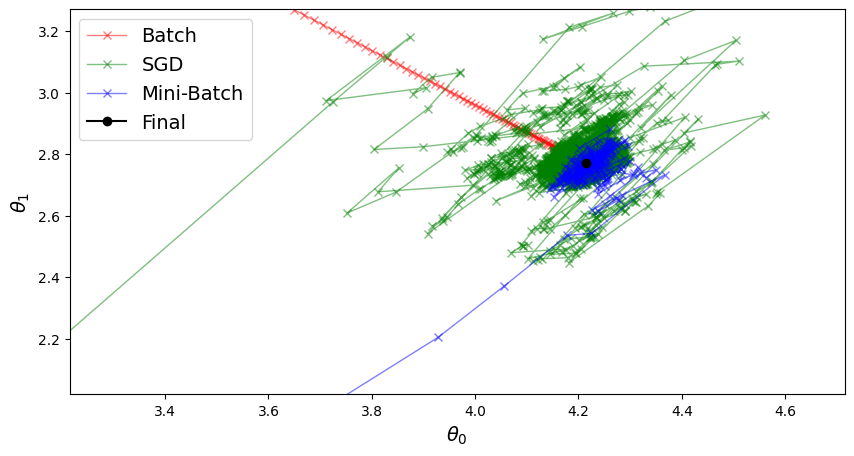

In [70]:
labels = ["Batch", "SGD", "Mini-Batch"]
color_maps = ["r-x", "g-x", "b-x"]
theta_paths = [theta_path_batch, theta_path_sgd, theta_path_mgd]

compare_theta_paths(theta_best, theta_paths, color_maps, labels)

## Polynomial Regression

In [71]:
# Generate some data using a polynomial function
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

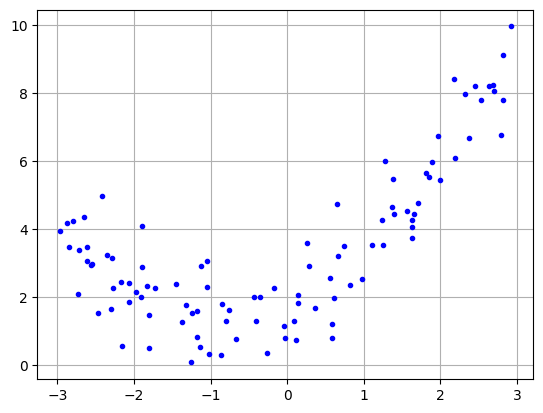

In [73]:
plt.plot(X, y, "b.")
plt.grid()

In [74]:
# We simply add powers of the data as new features
# Then, linear regression can be applied to the new data
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [75]:
print(f"Original data: {X[0].item()}")
print(f"Transformed data: {X_poly[0]}")

Original data: -0.752759286915825
Transformed data: [-0.75275929  0.56664654]


In [76]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

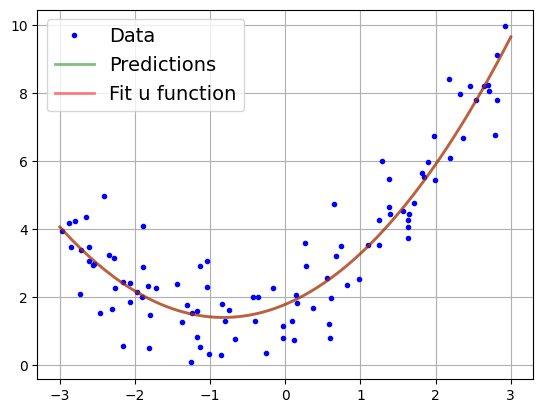

In [98]:
def polinomial_function(x, theta):
	return theta[0] + theta[1] * x + theta[2] * x**2

X_new = np.linspace(-3, 3, 100).reshape(100, 1)

y_new = polinomial_function(X_new, [lin_reg.intercept_.item(), lin_reg.coef_[0][0].item(), lin_reg.coef_[0][1].item()])

X_new_poly = poly_features.transform(X_new)
y_preds = lin_reg.predict(X_new_poly)

plt.plot(X, y, "b.", label='Data')
plt.plot(X_new, y_preds, "g-", linewidth=2, label='Predictions', alpha=0.5)
plt.plot(X_new, y_new, "r-", linewidth=2, label='Fit u function', alpha=0.5)
plt.grid()
plt.legend()